This Notebook is a library of functions for numerics of the incoherence simulations.

In [1]:
using BSON: @load
using Flux
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [84]:
"""
    optimise(init_z, loss, opt, tolerance, [out_toggle = 0,][max_iter = 1_000_000])

    Optimization that stops when the gradient is small enough
"""
function optimise(opt, loss; init, tolerance, out_toggle = 0, max_iter = 1_000_000)
    tol2 = tolerance^2
    z = init
    ps = Flux.params(z)
    iter=1
    succ_error = 1.0
    while succ_error > tol2 && (iter <= max_iter || @warn "Max num. iterations reached")
        grads = gradient(() -> loss(z), ps)
        update!(opt, z, grads[z])
        succ_error = sum(abs2, grads[z])
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  Loss: ", string(loss(z)))
        end
        iter += 1
    end
    return z
end

optimise

In [14]:
println("$(sqrt(2))")

1.4142135623730951


In [3]:
function get_rand_model(k,mid,n)
    W₂ = rand(Float64, (n, mid))
    W₁ = rand(Float64, (mid,k))
    return x -> W₂*relu.(W₁*x)
end

get_rand_model (generic function with 1 method)

In [4]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:])
end

sample_fourier (generic function with 1 method)

In [104]:
function recover_signal(measurements, measure, model, code_dim)
    function loss(signal_guess)
        return sum(abs2, measure(model(signal_guess)) - measurements)
    end
    
    return model(optimise( Flux.Optimise.Descent(1.2e-4), loss, init=rand(code_dim), tolerance=1e-10, out_toggle=20000))
end

recover_signal (generic function with 1 method)

In [100]:
k = 20
mid = 100
n = 400
aimed_m = 23
num_meas, measure_mat = sample_fourier(aimed_m, n)
measure(x) = measure_mat*x
random_model = get_rand_model(k,mid,n)
#signal in range
true_signal = random_model(rand(Float64, k))
measurements = measure(true_signal);

In [105]:
@time recovered_signal = recover_signal(measurements, measure, random_model, k)
println("The distance between signals is ", norm(recovered_signal - true_signal))
println("The size of the true signal is ", norm(true_signal))

====> In Gradient: Iteration: 20000 grad_size: 5.486575571612964e-6 tolerance: 1.0e-10  Loss: 0.0009341807618805881
====> In Gradient: Iteration: 40000 grad_size: 3.752344290413065e-7 tolerance: 1.0e-10  Loss: 4.375763743644386e-6
====> In Gradient: Iteration: 60000 grad_size: 2.5704813596449484e-8 tolerance: 1.0e-10  Loss: 2.0534732135462785e-8
====> In Gradient: Iteration: 80000 grad_size: 1.7609202211758725e-9 tolerance: 1.0e-10  Loss: 9.636952319295716e-11
====> In Gradient: Iteration: 100000 grad_size: 1.2063273262357786e-10 tolerance: 1.0e-10  Loss: 4.522626202637418e-13
 11.216442 seconds (27.45 M allocations: 42.674 GiB, 6.97% gc time, 3.11% compilation time)
The distance between signals is 1.7822367146940335e-5
The size of the true signal is 5557.832420673661


In [9]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end

function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:])
end

sample_Fourier (generic function with 1 method)

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [12]:
#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

# sampling rows of DCT matrix for outer layer
sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling) #number of neurons n_1
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]' # subsampled DCT
B = randn(x_dim, ndm1)/sqrt(x_dim) #random matrix thats used in convex combination

W1 = randn(ndm1, 20)/sqrt(ndm1) #random inner layer weight matrix

I(x) = x
z = randn(k) # ground code vector

β_list = .7:.01:1
trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B

        #setup the generative network 
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        # subsampling DCT for measurement matrix
        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        # measurement vector using subsampled DCT matrix
        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        # run gradient descent to solve the least squares problem
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        # save results
        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
    #save results
    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end


In [21]:
Pkg.instantiate()


Precompiling project...
  ✓ IntelOpenMP_jll
  ✓ MKL_jll
  ✓ FFTW
  ✓ FFTViews
  ✓ ImageFiltering
  ✓ ImageQualityIndexes
  ✓ ImageSegmentation
  ✓ Images
  8 dependencies successfully precompiled in 20 seconds (283 already precompiled)
  6 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


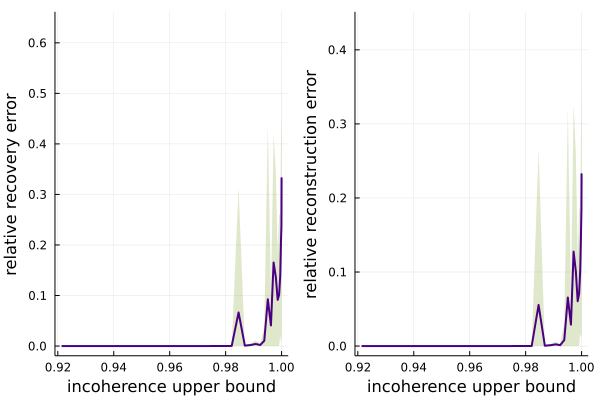

In [22]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=2)
std_recov = std(recovery_error_matrix[:, 2:end], dims=2)
plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false )


average_recon = mean(recon_error_matrix[:, 2:end], dims=2)
std_recon = std(recon_error_matrix[:, 2:end], dims=2)
plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )

plot(p1,p2,layout = 2)


The plot above shows a positive dependence of incoherence on recovery of the latent code signal $z_0$. The incoherence shown in figure is with respect to the last layer matrix and $A$ which equals
$$ \sup_{x\in\mathcal{R}(A_2)\cap \mathcal{S}^{n-1}} \|A x\|_\infty = \max_{i \in [n]}\left\{\sup_{u\in\mathbb{R}^{n_1}} \langle a_i, A_2 u\rangle \text{ s.t. } \|Au\|_2 = 1 \right\} = \max_{i \in [n]}\left\{\frac{\|A_2^\top a_i\|_2^2}{\|A_2A_2^\top a_i\|_2}\right\}$$
and only provides an upper bound to the incoherence of the GNN w.r.t $A$ given by
$$ \sup_{x\in\mathcal{R}(G)\cap \mathcal{S}^{n-1}}\|A x\|_\infty.$$
Here, $A$ is a unitary matrix and satisfies $A^\top A = AA^\top = I$ 


In [26]:
savefig(p1, "./Fourier/recov_error_2.pdf")
savefig(p2, "./Fourier/recon_error_2.pdf")
save("./Fourier/recovery_error_matrix_2.jld", "error", recovery_error_matrix, "α_list", α_list)
save("./Fourier/recon_error_matrix_2.jld", "error", recon_error_matrix, "α_list", α_list)


In the next experiment, we use a trained network and use one of its weight matrix to fix the entries of the inner layer matrix $A_1$. This helps reduce the incoherence of the $G(x)$ with respect $A$ (as compared to when $A_1$ contained gaussian entries). The plot generated if from the complete range of $\beta$ from 0 to 1.

In [27]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

epoch_to_load = 3
# Load the model and test set loader
_, _, decoder = load_model("MNIST", epoch_to_load)

#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling)
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]'
B = randn(x_dim, ndm1)/sqrt(x_dim)


W1 = Flux.params(decoder)[1][1:ndm1,:]
_, s, _ = svd(W1)
W1 = W1 / s[1]

I(x) = x;


Loading model...Done


In [29]:
z = randn(k)

β_list = 0:.1:1

trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B
        #setup a synthetic problem
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        y = F_sub*G(z)

        stepsize = 1
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
   recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
   recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end


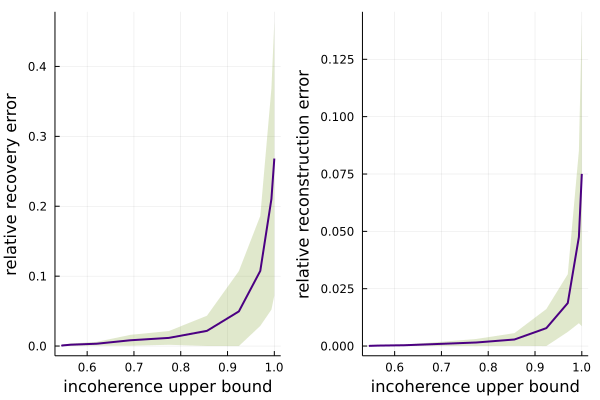

In [30]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recovery_error_matrix[:, 2:end], dims=2)
std_recov = std(recovery_error_matrix[:, 2:end], dims=2)
plot(α_list, average_recov + std_recov, fillrange = max.(0, average_recov - std_recov), fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false )


average_recon = mean(recon_error_matrix[:, 2:end], dims=2)
std_recon = std(recon_error_matrix[:, 2:end], dims=2)
plot(α_list, average_recon + std_recon, fillrange = max.(0, average_recon - std_recon), fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )

plot(p1,p2,layout = 2)


In [31]:
savefig(p1, "Fourier/recov_error_trained_2.pdf")
savefig(p2, "Fourier/recon_error_trained_2.pdf")
save("Fourier/recovery_error_matrix_trained_2.jld", "error", recovery_error_matrix, "α_list", α_list)
save("Fourier/recon_error_matrix_trained_2.jld", "error", recon_error_matrix, "α_list", α_list)


Extra tuning codes

In [32]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

epoch_to_load = 3
# Load the model and test set loader
_, _, decoder = load_model("result/MNIST", epoch_to_load)

#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling)
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

W1 = Flux.params(decoder)[1][50+1:50+ndm1,:]
_, s, _ = svd(W1)
W1 = W1 / s[1]


A = F[nnzindex,:]'
B = randn(x_dim, ndm1)/sqrt(x_dim)
I(x) = x


Loading model...

LoadError: SystemError: opening file "result/MNIST/model-3.bson": No such file or directory

In [212]:
β = 0
Aint = β*A + (1-β) * B
#setup a synthetic problem
G = Chain(
    Dense(20, ndm1, relu, bias = false; initW =(out,in) -> W1),
    Dense(ndm1, x_dim, I, bias = false; initW =(out,in) -> Aint)
)

sampling = rand(Bernoulli(.25), x_dim)
sampling = convert.(Int, sampling)
m = sum(sampling)
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end
F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

y = F_sub*G(z)

stepsize = 1
tolerance = 1e-14
max_iter = 3000
out_toggle = 2001

z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - real(z_rec))/norm(z)
recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
Fn = F  
println("recov $recov_error, recon $recon_error")
α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

====> In Gradient: Iteration: 2001 Successive error: 1.101256236326512e-5
recov 8.023611877878882e-5, recon 1.1225554045732819e-5


0.5485472826061283

In [201]:
Aint2 = Aint * ( W1)
α = maximum(sum((Fn*Aint2)' .* (Fn*Aint2)', dims = 1) ./ sqrt.(sum((Fn*Aint2*Aint2')' .* (Fn*Aint2*Aint2')', dims = 1)))

0.2361506614883343

In [167]:
W2 = W1
W2[:,1] = zeros(89); W2[1,1] = 1
W2[:,2] = zeros(89); W2[2,2] = 1

W2


89×20 Matrix{Float32}:
 1.0  0.0   0.00974893  -0.00921012  …  -0.0254752    -0.132524
 0.0  1.0   0.0150396   -0.0429809      -0.00668458    0.14918
 0.0  0.0   0.00835652   0.0399076      -0.00343647   -0.00848262
 0.0  0.0  -0.0228678   -0.0628122      -0.0137943    -0.0685252
 0.0  0.0   0.0196851   -0.0536446      -0.0221053    -0.065805
 0.0  0.0   0.00548573   0.00316324  …   0.00402515    0.0876435
 0.0  0.0  -0.0250458   -0.0108641      -0.0160323    -0.0814496
 0.0  0.0  -0.00579691   0.0187786       0.00994273   -0.0880214
 0.0  0.0  -0.0156306   -0.0475449      -0.00322415   -0.166059
 0.0  0.0   0.0219221   -0.0203175       0.0310201     0.00529595
 ⋮                                   ⋱                
 0.0  0.0  -0.00952288   0.0247436   …  -0.00926326   -0.17316
 0.0  0.0   0.010333    -0.0367166       0.0120047     0.0631138
 0.0  0.0   0.0479774    0.0105341       0.000972114   0.187123
 0.0  0.0  -0.0124389    0.00605544      0.0324024     0.147581
 0.0  0.0  -0.04741